In [12]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset
from torchvision.models import mobilenet_v2

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

cuda:0
1
NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
bs = 64
crop_size = 224

In [6]:
train_transform = transforms.Compose([
  transforms.RandomRotation(10),
  transforms.RandomResizedCrop(crop_size, scale=(0,7, 1)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

In [7]:
train_set = MultilabelDataset("data//train_label.csv", "data//train//", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data//test_label.csv", "data//test//", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
label2cat = train_set.classes
label2cat

['neckHead', 'breast', 'wing', 'thigh', 'feet']

In [9]:
class customeMNetV2(nn.Module):
  def __init__(self, output_size) :
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()
    self.mnet.classifier = nn.Sequential(
      nn.Linear(1280, output_size),
      nn.Sigmoid()
    )
  
  def forward(self, x) :
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False
  
  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [10]:
config = set_config({
  "output_size" : len(label2cat),
  "batch_size" : bs,
  "crop_size" : crop_size
})

In [13]:
model = customeMNetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
Callback = Callback(model, config, early_stop_patience=2, outdir="model")

c:\Users\ibrak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ibrak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == "train": model.train()
  elif mode == "test": model.eval()

  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == "train" :
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  
  cost = cost / len(dataset)
  return cost

c:\Users\ibrak\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def fitModel():
  while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device) 
    with torch.no_grad():
      test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    Callback.log(train_cost, test_cost)

    # Checkpoint
    Callback.save_checkpoint()

    #Runtime Plotting
    Callback.cost_runtime_plotting()

    #Early Stopping
    if Callback.early_stopping (model, monitor="test_cost"):
      Callback.plot_cost()
      break

Test:  20%|██        | 1/5 [00:01<00:05,  1.27s/it]c:\Users\ibrak\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Test: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]



Epoch     1
Train_cost  = 0.5736 | Test_cost  = 0.4961 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]



Epoch     2
Train_cost  = 0.4758 | Test_cost  = 0.4386 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]



Epoch     3
Train_cost  = 0.4336 | Test_cost  = 0.4094 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch     4
Train_cost  = 0.4086 | Test_cost  = 0.3848 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch     5
Train_cost  = 0.3944 | Test_cost  = 0.3713 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch     6
Train_cost  = 0.3741 | Test_cost  = 0.3598 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch     7
Train_cost  = 0.3750 | Test_cost  = 0.3501 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch     8
Train_cost  = 0.3551 | Test_cost  = 0.3436 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Epoch     9
Train_cost  = 0.3562 | Test_cost  = 0.3360 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]



Epoch    10
Train_cost  = 0.3423 | Test_cost  = 0.3307 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    11
Train_cost  = 0.3404 | Test_cost  = 0.3330 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3307


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    12
Train_cost  = 0.3394 | Test_cost  = 0.3300 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    13
Train_cost  = 0.3334 | Test_cost  = 0.3266 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    14
Train_cost  = 0.3272 | Test_cost  = 0.3291 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3266


Test: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]



Epoch    15
Train_cost  = 0.3294 | Test_cost  = 0.3297 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3266
==> Execute Early Stopping at epoch: 15 | Best test_cost: 0.3266
==> Best model is saved at model


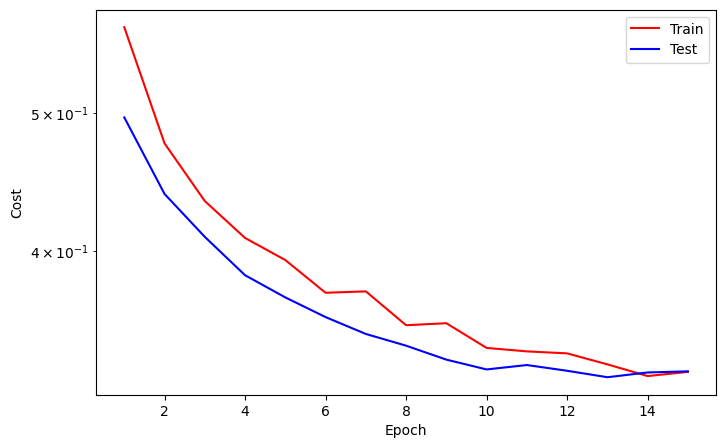

In [16]:
fitModel()

### Fase 2 : Fine Tunning (lr dikecilin, patiecnce ditambah)

In [17]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
Callback.reset_early_stop()
Callback.early_stop_patience = 5

Test: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]



Epoch    16
Train_cost  = 0.3347 | Test_cost  = 0.3161 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]



Epoch    17
Train_cost  = 0.3151 | Test_cost  = 0.3044 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]



Epoch    18
Train_cost  = 0.3091 | Test_cost  = 0.2971 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]



Epoch    19
Train_cost  = 0.2981 | Test_cost  = 0.2924 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch    20
Train_cost  = 0.2943 | Test_cost  = 0.2884 | 


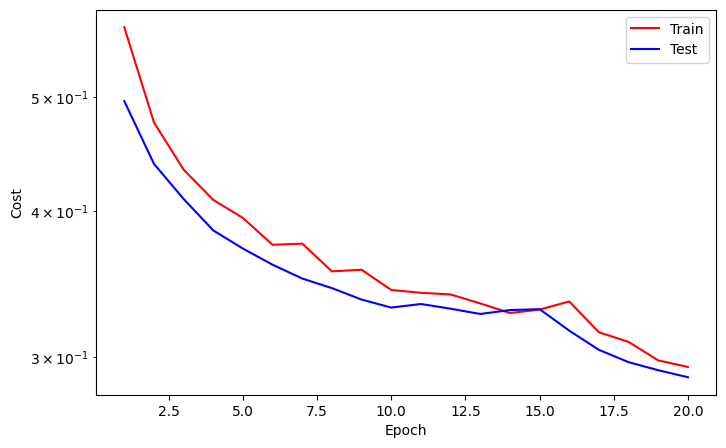

Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    21
Train_cost  = 0.2944 | Test_cost  = 0.2790 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]



Epoch    22
Train_cost  = 0.2758 | Test_cost  = 0.2743 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    23
Train_cost  = 0.2799 | Test_cost  = 0.2707 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]



Epoch    24
Train_cost  = 0.2657 | Test_cost  = 0.2665 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]



Epoch    25
Train_cost  = 0.2628 | Test_cost  = 0.2634 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    26
Train_cost  = 0.2583 | Test_cost  = 0.2604 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    27
Train_cost  = 0.2500 | Test_cost  = 0.2598 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    28
Train_cost  = 0.2593 | Test_cost  = 0.2580 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    29
Train_cost  = 0.2548 | Test_cost  = 0.2522 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]



Epoch    30
Train_cost  = 0.2439 | Test_cost  = 0.2523 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2522


Test: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]



Epoch    31
Train_cost  = 0.2358 | Test_cost  = 0.2506 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]



Epoch    32
Train_cost  = 0.2376 | Test_cost  = 0.2502 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]



Epoch    33
Train_cost  = 0.2318 | Test_cost  = 0.2483 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    34
Train_cost  = 0.2271 | Test_cost  = 0.2451 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    35
Train_cost  = 0.2334 | Test_cost  = 0.2435 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    36
Train_cost  = 0.2295 | Test_cost  = 0.2414 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    37
Train_cost  = 0.2319 | Test_cost  = 0.2382 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    38
Train_cost  = 0.2224 | Test_cost  = 0.2386 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2382


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    39
Train_cost  = 0.2249 | Test_cost  = 0.2347 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch    40
Train_cost  = 0.2222 | Test_cost  = 0.2353 | 


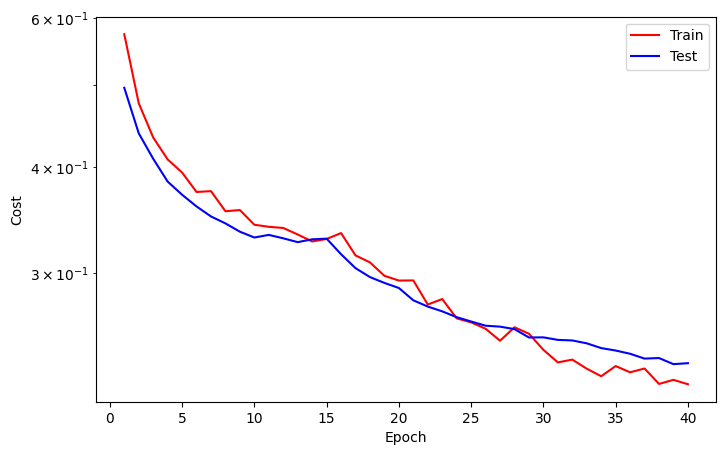

==> EarlyStop patience =  1 | Best test_cost: 0.2347


Test: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]



Epoch    41
Train_cost  = 0.2161 | Test_cost  = 0.2340 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Epoch    42
Train_cost  = 0.2147 | Test_cost  = 0.2299 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    43
Train_cost  = 0.2087 | Test_cost  = 0.2283 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]



Epoch    44
Train_cost  = 0.2127 | Test_cost  = 0.2270 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    45
Train_cost  = 0.2109 | Test_cost  = 0.2265 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    46
Train_cost  = 0.2029 | Test_cost  = 0.2265 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2265


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    47
Train_cost  = 0.2089 | Test_cost  = 0.2252 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    48
Train_cost  = 0.2073 | Test_cost  = 0.2240 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]



Epoch    49
Train_cost  = 0.1942 | Test_cost  = 0.2232 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]



Epoch    50
Train_cost  = 0.1984 | Test_cost  = 0.2206 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    51
Train_cost  = 0.1924 | Test_cost  = 0.2217 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2206


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    52
Train_cost  = 0.1839 | Test_cost  = 0.2213 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2206


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    53
Train_cost  = 0.1847 | Test_cost  = 0.2204 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    54
Train_cost  = 0.1873 | Test_cost  = 0.2210 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2204


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    55
Train_cost  = 0.1940 | Test_cost  = 0.2205 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2204


Test: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]



Epoch    56
Train_cost  = 0.1815 | Test_cost  = 0.2190 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]



Epoch    57
Train_cost  = 0.1853 | Test_cost  = 0.2182 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    58
Train_cost  = 0.1847 | Test_cost  = 0.2168 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]



Epoch    59
Train_cost  = 0.1810 | Test_cost  = 0.2184 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2168


Test: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch    60
Train_cost  = 0.1872 | Test_cost  = 0.2166 | 


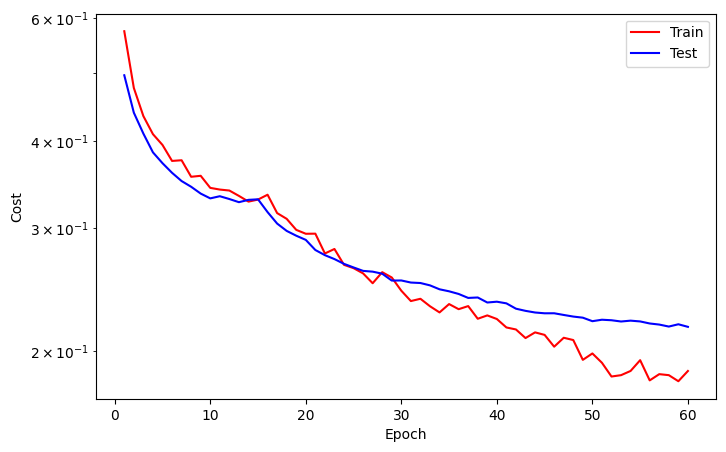

Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    61
Train_cost  = 0.1692 | Test_cost  = 0.2149 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]



Epoch    62
Train_cost  = 0.1654 | Test_cost  = 0.2164 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2149


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    63
Train_cost  = 0.1762 | Test_cost  = 0.2142 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]



Epoch    64
Train_cost  = 0.1711 | Test_cost  = 0.2112 | 


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    65
Train_cost  = 0.1720 | Test_cost  = 0.2121 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2112


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    66
Train_cost  = 0.1655 | Test_cost  = 0.2106 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]



Epoch    67
Train_cost  = 0.1694 | Test_cost  = 0.2081 | 


Test: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]



Epoch    68
Train_cost  = 0.1649 | Test_cost  = 0.2093 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2081


Test: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



Epoch    69
Train_cost  = 0.1607 | Test_cost  = 0.2107 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2081


Test: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]



Epoch    70
Train_cost  = 0.1691 | Test_cost  = 0.2109 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2081


Test: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]



Epoch    71
Train_cost  = 0.1558 | Test_cost  = 0.2092 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2081


Test: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]



Epoch    72
Train_cost  = 0.1569 | Test_cost  = 0.2084 | 
==> EarlyStop patience =  5 | Best test_cost: 0.2081
==> Execute Early Stopping at epoch: 72 | Best test_cost: 0.2081
==> Best model is saved at model


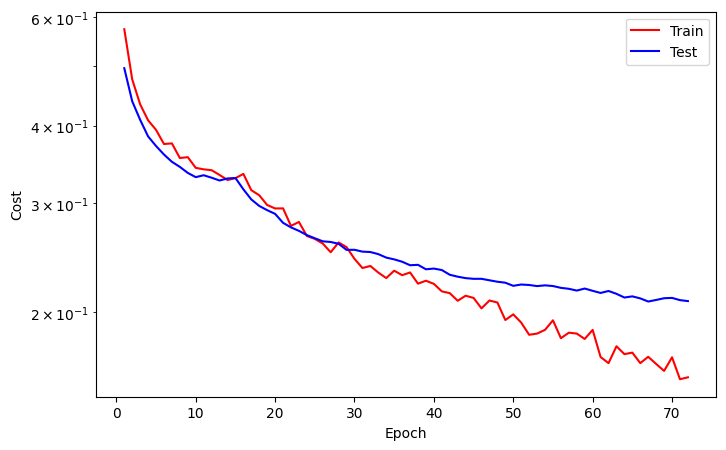

In [18]:
fitModel()

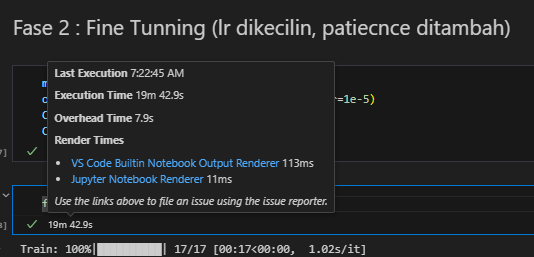

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [28]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = (output > 0.5).to(torch.float32)

preds

tensor([[0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0

In [24]:
len(preds)

64

In [21]:
torch.save(model.state_dict(), "model//customeMNetV2.pth")

In [29]:
def convert_to_label(x):
  return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

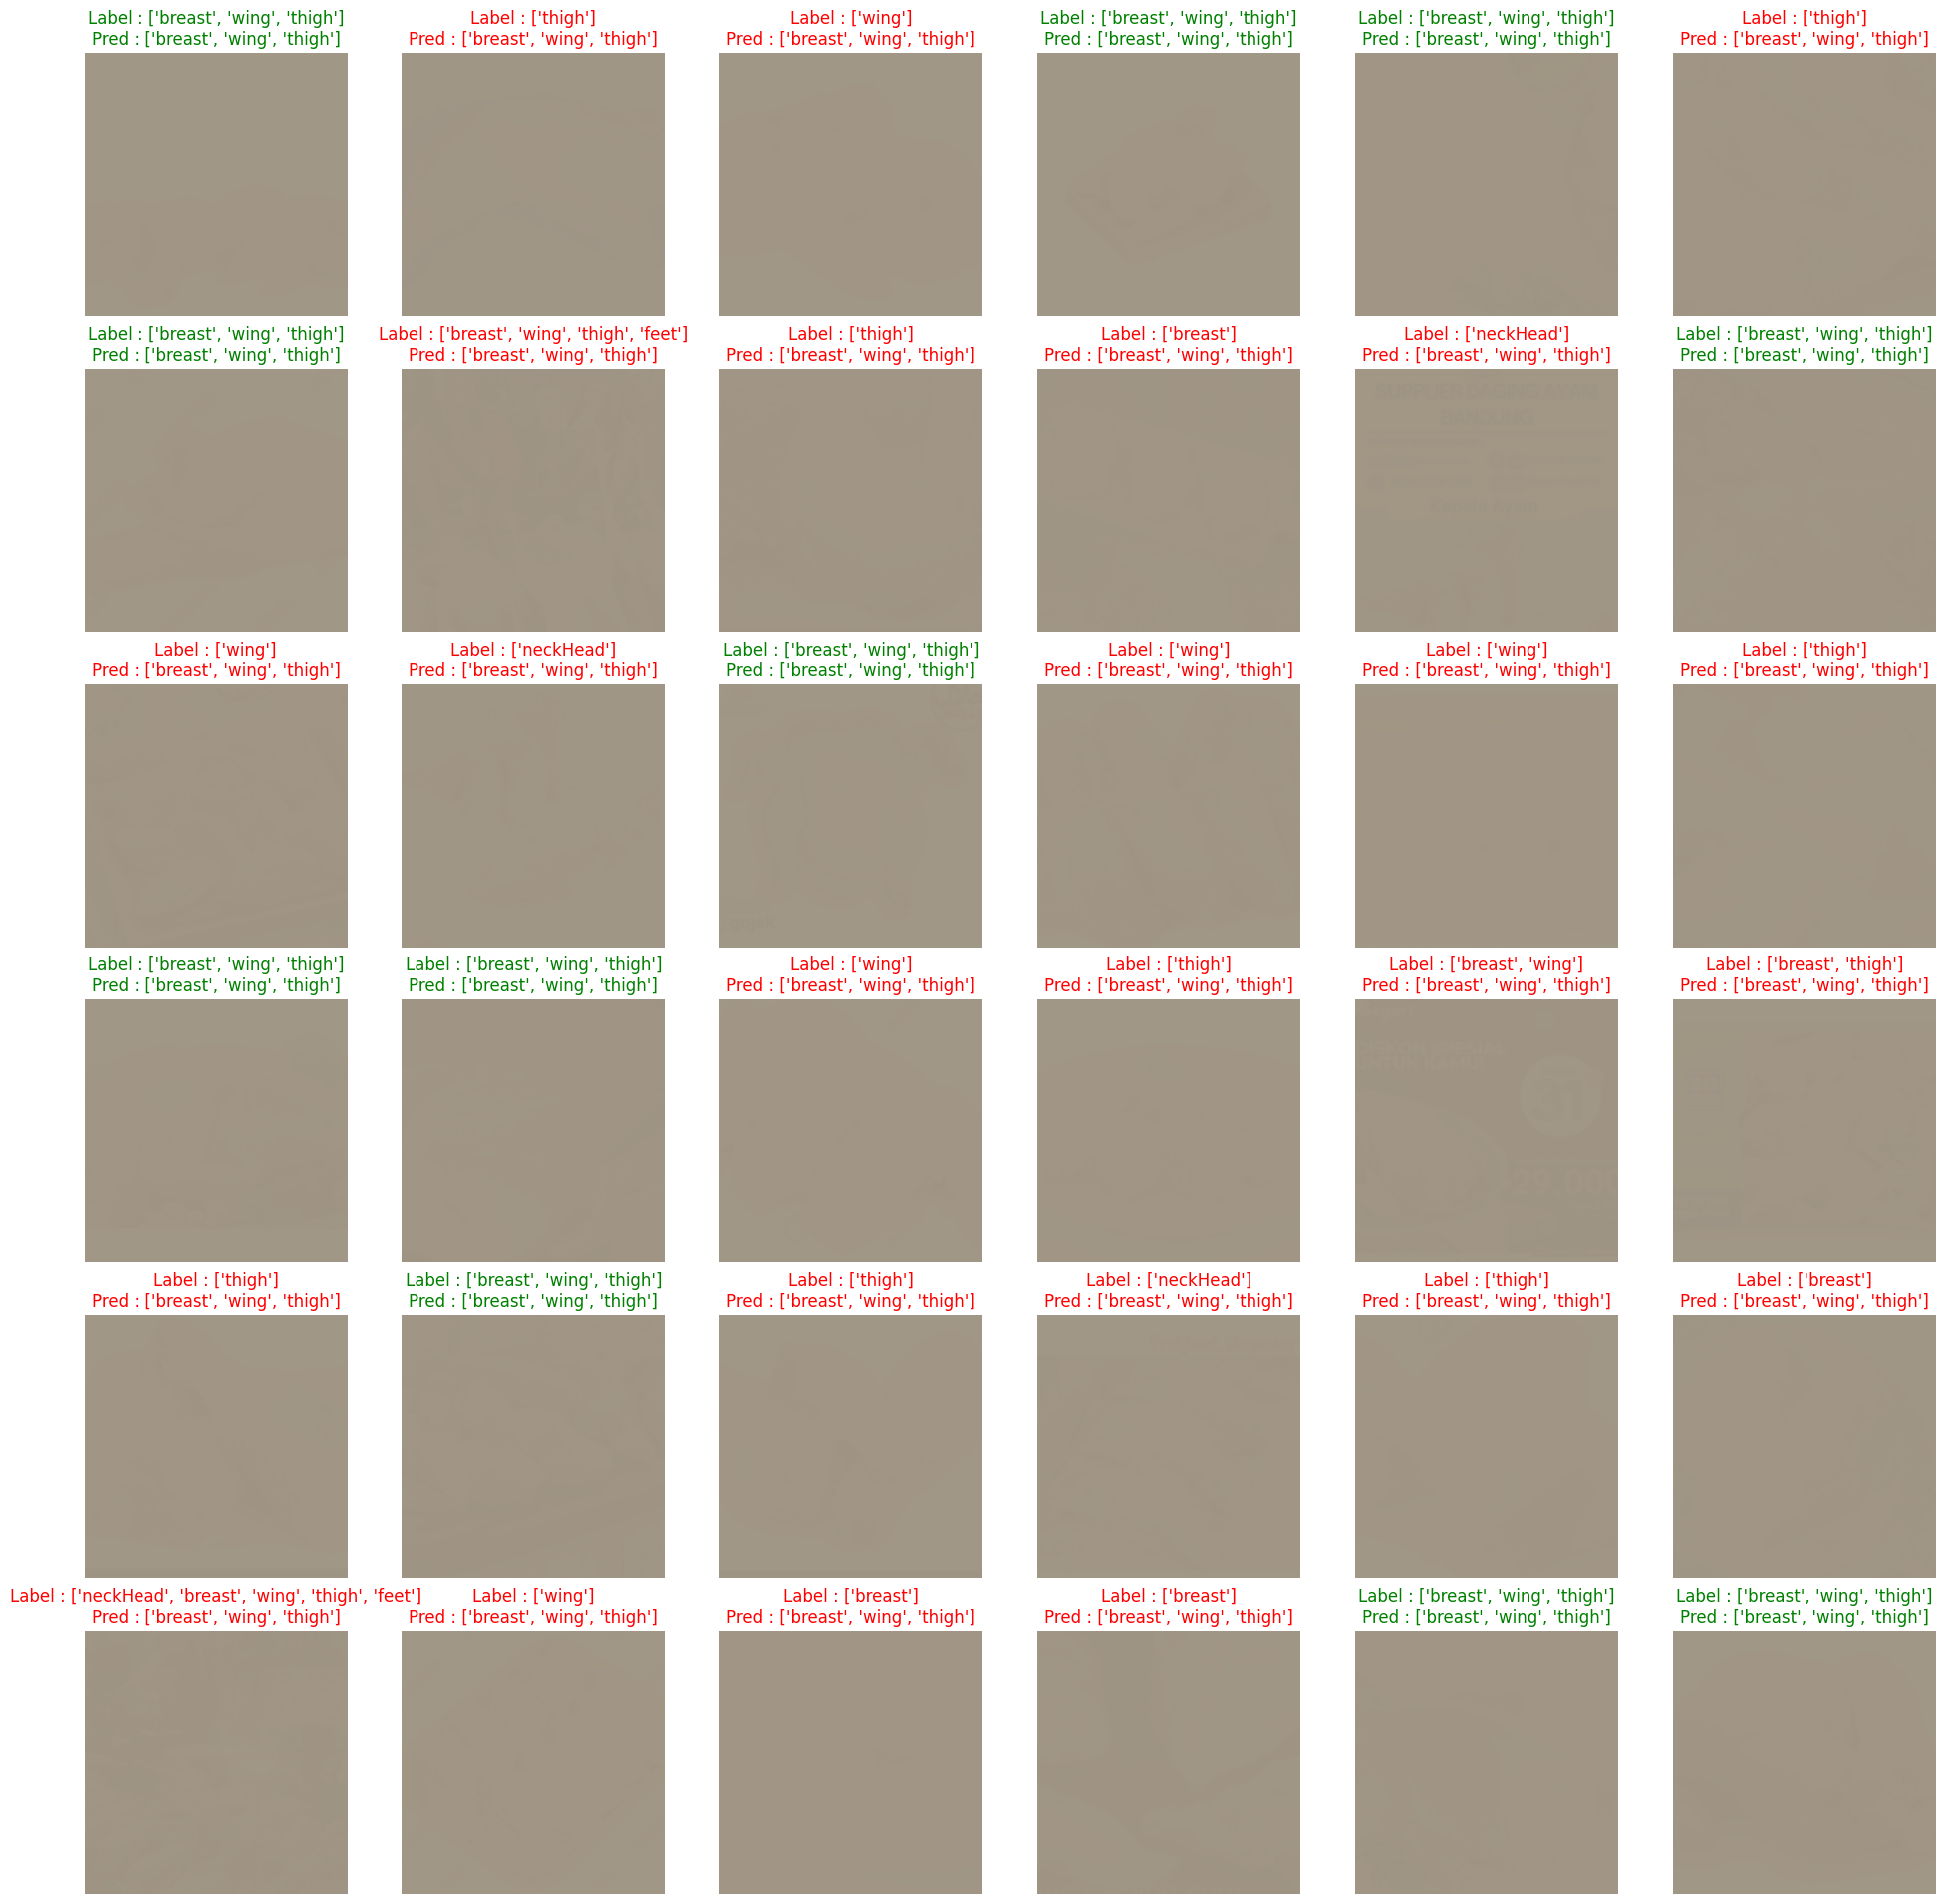

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))

for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
  font = {"color": "r"} if (pred != label).any() else {"color": "g"}
  label, pred = convert_to_label(label), convert_to_label(pred)
  ax.set_title(f"Label : {label}\nPred : {pred}", fontdict = font)
  ax.axis("off")